In [41]:
from sklearn import datasets
from sklearn import model_selection  
from sklearn import linear_model
from sklearn import metrics
from sklearn import tree
from sklearn import neighbors
from sklearn import svm
from sklearn import ensemble
from sklearn import cluster
from sklearn import preprocessing
from sklearn import pipeline

import numpy as np
import pandas as pd
from datetime import datetime

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import seaborn.objects as so

In [42]:
redfin = pd.read_csv('../3_data_cleaned/redfin_market_tracker_LI_cleanup.csv')
redfin = redfin.dropna()
print(redfin.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1366 entries, 0 to 1405
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   region                   1366 non-null   object 
 1   property_type            1366 non-null   object 
 2   property_type_id         1366 non-null   int64  
 3   median_sale_price        1366 non-null   float64
 4   median_list_price        1366 non-null   float64
 5   median_ppsf              1366 non-null   float64
 6   median_list_ppsf         1366 non-null   float64
 7   homes_sold               1366 non-null   float64
 8   pending_sales            1366 non-null   float64
 9   new_listings             1366 non-null   float64
 10  inventory                1366 non-null   float64
 11  months_of_supply         1366 non-null   float64
 12  median_dom               1366 non-null   float64
 13  avg_sale_to_list         1366 non-null   float64
 14  sold_above_list          1366

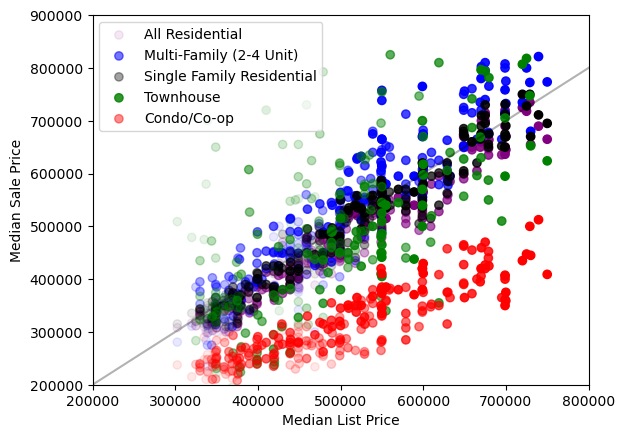

In [43]:
current_period = datetime.now().year

# Set labels, format and window cutoff
plt.xlabel('Median List Price')
plt.ylabel('Median Sale Price')
plt.xlim(200000, 800000)
plt.ylim(200000, 900000)

# Color by property type
color_map = {
    'Single Family Residential': 'black',
    'Condo/Co-op': 'red',
    'Townhouse': 'green',
    'Multi-Family (2-4 Unit)': 'blue',
    'All Residential': 'purple'
    }
colors = [color_map[x] for x in redfin['property_type']]

for property_type in set(redfin['property_type']):
    xi = redfin[redfin['property_type'] == property_type]['median_list_price']
    yi = redfin[redfin['property_type'] == property_type]['median_sale_price']

    # Depending on age, we'll make older data more transparent
    periodi = redfin[redfin['property_type'] == property_type]['period'].str[:4].astype(int)
    alphai = 1 - (current_period - periodi) / (current_period - periodi.min())
    plt.scatter(xi, yi, c=color_map[property_type], label=property_type, alpha=alphai)

# Plot a diagonal x=y line
plt.plot([200000, 800000], [200000, 800000], c='black', alpha=0.3)

plt.legend()
plt.show()


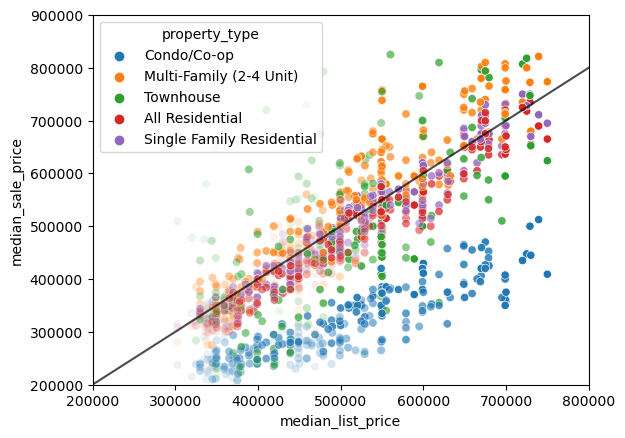

In [44]:
def plotRedfinScatter(xVal, yVal):
    plot = sns.scatterplot(x=xVal, y=yVal, data=redfin,
                hue='property_type',
                alpha=getYearAlpha(redfin['period']))
    plot.set(xlim=(200000, 800000), ylim=(200000, 900000))
    return plot

def getYearAlpha(data):
    period = data.str[:4].astype(int)
    return 1 - (current_period - period) / (current_period - period.min())

plot = plotRedfinScatter('median_list_price', 'median_sale_price')
plot.plot([200000, 800000], [200000, 800000], c='black', alpha=0.7)

### Takeaways:

- People are listing Condos and Co-ops at a higher price then they are actually being sold for.
- Multi-Family homes are either being sold at the listing price, or generally higher. Faded (historical) points show this wasn't always the case.
- As time went on, house prices trended both upwards and more towards the listing price rather than listed high / sold low.

## Making simple Linear Regression Model

In [45]:
# Prepare data for regression
X = redfin[['median_list_price', 'property_type_id', 'timestamp', 'interest_rate']]
y = redfin['median_sale_price']

# Split data into training and test sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.7)

regressor = linear_model.LinearRegression()

# Fit the regressor
regressor.fit(X_train, y_train)

# Make predictions
y_pred = regressor.predict(X_test)

In [46]:
result = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
# append result to Redfin
redfin['predicted_median_sale_price_simple_linear'] = regressor.predict(X)
print(result.head(10))
# Calculate performance metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('R-squared:', metrics.r2_score(y_test, y_pred))

         Actual      Predicted
944   1001875.0  755023.022943
903    380000.0  358156.997688
616    559000.0  555289.182955
116    415000.0  409549.606697
434    390000.0  373019.621006
99     621888.0  516951.358415
472    210500.0  386640.973033
1065   310000.0  254341.431746
1339   430000.0  381876.112425
1118   530000.0  428859.017517
Mean Absolute Error: 76249.50945548322
R-squared: 0.49958395836060054


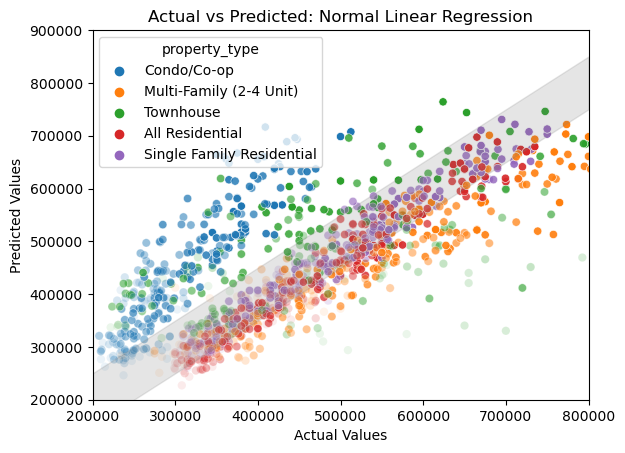

In [47]:
#Seaborn plot
plot = plotRedfinScatter('median_sale_price', 'predicted_median_sale_price_simple_linear')
plot.set(xlabel='Actual Values', ylabel='Predicted Values', title='Actual vs Predicted: Normal Linear Regression')
plot.fill_between([200000, 800000], [150000, 750000], [250000, 850000],  color='gray', alpha=0.2)

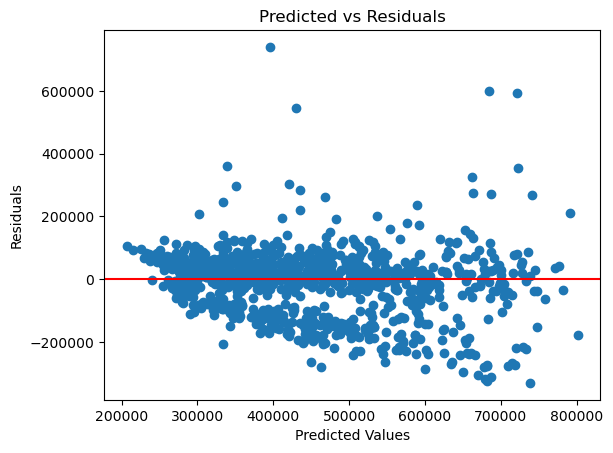

In [ ]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Predicted vs Residuals')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

In [51]:
# Let's try a different regression model

regressor = tree.DecisionTreeRegressor()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

result = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
redfin['predicted_median_sale_price_decision_tree'] = regressor.predict(X)
print(result.head(10))

# Calculate performance metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('R-squared:', metrics.r2_score(y_test, y_pred))


         Actual  Predicted
944   1001875.0   818000.0
903    380000.0   380000.0
616    559000.0   575000.0
116    415000.0   380000.0
434    390000.0   400000.0
99     621888.0   600000.0
472    210500.0   247200.0
1065   310000.0   299000.0
1339   430000.0   455000.0
1118   530000.0   410000.0
Mean Absolute Error: 52680.37199582027
R-squared: 0.6192013484428465


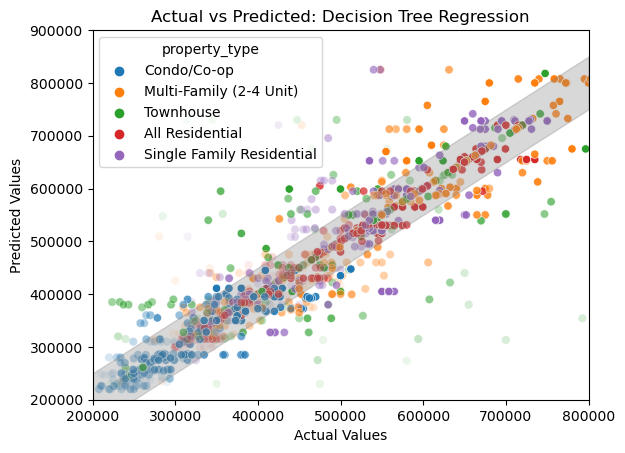

In [52]:

#Seaborn plot
plot = plotRedfinScatter('median_sale_price', 'predicted_median_sale_price_decision_tree')
plot.set(xlabel='Actual Values', ylabel='Predicted Values', title='Actual vs Predicted: Decision Tree Regression')
plot.fill_between([200000, 800000], [150000, 750000], [250000, 850000],  color='gray', alpha=0.3)